This file contains code for plotting and analysing the data created by the 'RunAll.sh' script. All created plots are exported to 'Data/Robust_Results/Plots'.

# Robust ACNO-MDP plotting

### Generic functions & constants

In [1]:
# Imports:
import numpy as np
import json
import math as m
import matplotlib
import matplotlib.pyplot as plt
import datetime
from scipy.signal import savgol_filter
import scipy.stats as sts
import warnings

Export_path = "Data/Robust_Results/"




def float_to_str(float):
        if np.isclose(float, 0):
                return "0"
        elif float<0:
                return "-" + float_to_str(-float)
        elif float >= 1:
                prefix = int(np.floor(float))
                return str(prefix) + float_to_str(float - prefix)[1:]
        elif float < 1:
                cutlength = np.min([len(str(float)), 7])
                return "0" + (str(float)[:cutlength].rstrip('0')[2:])

def collect_data_from_files(
        algnames:list, resultvars:list, tests:np.ndarray,
        str1:str, str2:str, str3:str,
        nmbr_runs:int = 1, plotEpStart:int = 0, plotEpEnd:int = -1,
        per_run_std:bool = False,
        smoothen:bool = False, window:int = 3, order:int = 1,
        opt:bool = False #this is a hack...
        ):
        
        nmbr_algs = len(algnames)
        nmbr_tests = len(tests)
        nmbr_results = len(resultvars)        
        avgs = np.zeros((nmbr_algs, nmbr_results, nmbr_tests))
        stds = np.zeros((nmbr_algs, nmbr_results, nmbr_tests))
        
        for (alg_iter, algname) in enumerate(algnames):
                for test_iter in range(nmbr_tests):
                        tstname = float_to_str(tests[test_iter])
                        filename = str1 + algname + str2 + tstname + str3
                        if opt:
                                filename = str1 + algname + str2 + tstname + "_p" + tstname + "_m-" + tstname + str3
                        
                        # Legacy name converion
                        try:
                                open(filename)
                        except FileNotFoundError:
                                filename = str1 + algname + str2 + tstname + "_p" + tstname + str3
                                try:
                                        open(filename)
                                except FileNotFoundError:
                                        if opt:
                                                filename = str1 + algname + str2 + tstname + "_p" + tstname + "_m-" + tstname + str3
                                        else:
                                                filename = str1 + algname + str2 + tstname + "_p" + tstname + "_m" + tstname + str3
                        if opt:
                                print(filename)



                        with open(filename) as file:
                                file_results = json.load(file)
                                for (result_iter, result_name) in enumerate(resultvars):
                                        this_results = np.array(file_results[result_name])
                                        avgs[alg_iter, result_iter, test_iter] = np.average(this_results[:,plotEpStart:plotEpEnd])
                                        
                                        if per_run_std:
                                                stds[alg_iter, result_iter, test_iter] = np.std( np.average(this_results, axis=1) )             / np.sqrt(nmbr_runs)
                                        else:
                                                if plotEpEnd == -1:
                                                        plotEpEnd = np.size(this_results[0])
                                                stds[alg_iter, result_iter, test_iter] = np.std( this_results[:,plotEpStart:plotEpEnd] )        / np.sqrt( (plotEpEnd - plotEpStart) * nmbr_runs )
                                        
        if smoothen:
                for (alg_iter, algname) in enumerate(algnames):
                        for (result_iter, result_name) in enumerate(resultvars):
                                avgs[alg_iter, result_iter] = savgol_filter(avgs[alg_iter, result_iter],window, order, mode="nearest")
                                stds[alg_iter, result_iter] = savgol_filter(stds[alg_iter, result_iter],window, order, mode="nearest")
        return (avgs, stds)

def plot_lines(
        ys:np.ndarray, x:np.ndarray,
        stds:np.ndarray = None, conf_interval:float = 0.95,
        legend:np.ndarray = None, legend_columns=1, title:str="",
        xlabel:str = "", ylabel:str="", linestyle='-',
        show:bool=True, save:bool = False, savename:str = "Temp.pdf", clear:bool = False
):
        for (i, y) in enumerate(ys):
                if legend is not None:
                        plt.plot(x, y, label = legend[i], linestyle=linestyle)
                else:
                        plt.plot(x, y)
                if stds is not None:
                        rewardsmin, rewardsmax = sts.norm.interval(conf_interval, loc=y, scale=stds[i])
                        plt.fill_between(x, rewardsmin, rewardsmax, alpha=0.1)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.legend(ncol=legend_columns)
        if save:
                plt.savefig(savename)
        if show:
                plt.show()
        if clear:
                plt.clf()

### Test on Machine Maintenance

In [2]:
# # Regular runs
# plan_value = 0.8
# algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
# alphas = np.round(np.arange(start=0.8, stop=1.0, step=0.2), decimals=2)
# str1 = Export_path+"Maintenance/AMData_"; str2 = "_Maintenance_N20_r"; str3 ="_p{}_mc001.json".format(float_to_str(plan_value))

# nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(alphas)
# nmbr_extra_algs = 1
# all_avgs, all_stds = np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
# all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

# # Optimistic and pesimistic Control robustness
# algnames = ["ATM_Control_Robust"]
# str3 = "_p{}_m1_mc001.json".format(float_to_str(plan_value))
# all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

# str3 = "_p{}_m-1_mc001.json".format(float_to_str(plan_value))
# all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

# avg_rewards, std_rewards = all_avgs[:,0,:], all_stds[:,0,:]
# avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
# avg_steps, std_steps = all_avgs[:,1,:], all_stds[:,1,:]

# legend = ["ATM-avg", "ATM-pes", "R-ATM", "RC-ATM-pes", "RC-ATM-avg", "RC-ATM-opt"]

# xaxis = "Alpha (real)"
# yaxis_r = "Reward"
# yaxis_m = "Measurements"
# yaxis_s = "Steps"

# plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
# plot_lines(avg_rewards, alphas, std_rewards, legend=legend, xlabel=xaxis, ylabel=yaxis_r)
# plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
# plot_lines(avg_measures, alphas, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m)
# plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
# plot_lines(avg_steps, alphas, std_steps, legend=legend, xlabel=xaxis, ylabel=yaxis_s)
# # Without non-robust ATM
# # plot_lines(avg_rewards[1:], alphas, std_rewards[1:], legend=legend[1:])

Data\Temp1\AMData_ATM_Maintenance_N8_r08_p09_mc001.json
Data\Temp1\AMData_ATM_Maintenance_N8_r08_p09_mc001.json

### Test on 12x12 Frozen Lake

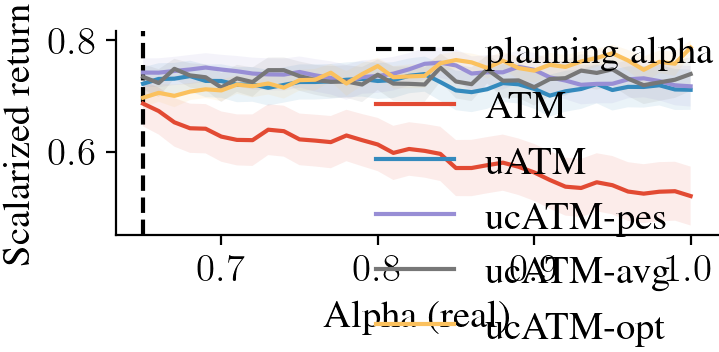

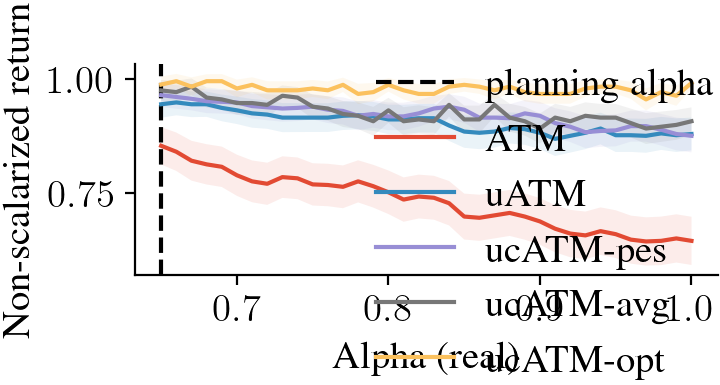

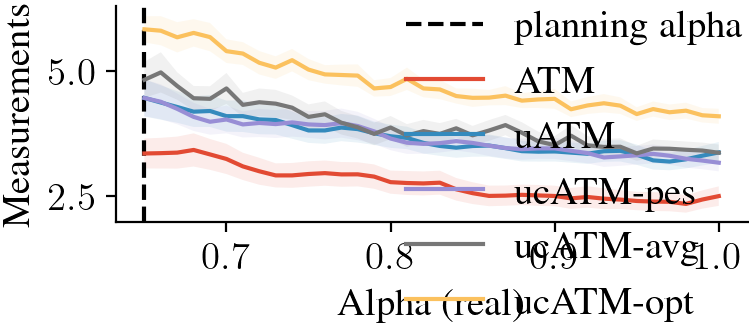

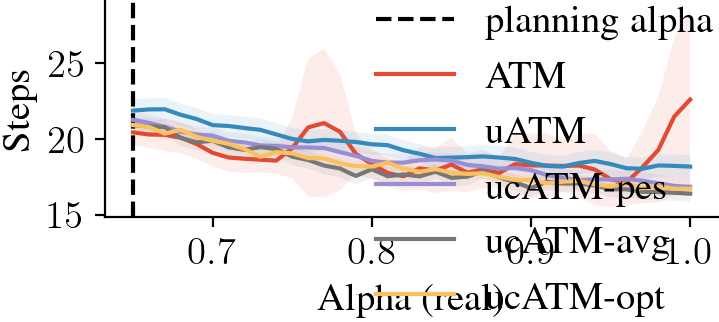

In [3]:
# Regular runs
plan_value = 0.65
# algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_Robust", "ATM_Control_Robust"]
algnames = [ "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = [ "ATM_RMDP", "ATM_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
alphas = np.round(np.arange(start=0.65, stop=1.01, step=0.01), decimals=2)
str1 = Export_path+"Lake/AMData_"; str2 = "_Lake_12_semi-slippery_r"; str3 = "_p{}_mc005.json".format(float_to_str(plan_value))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(alphas)
nmbr_extra_algs = 2
all_avgs, all_stds = np.empty((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.empty((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

# Optimistic and pesimistic Control robustness
algnames = ["ATM_Control_Robust"]
str3 = "_p{}_m1_mc005.json".format(float_to_str(plan_value))
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=False)

str3 = "_p{0}_m-{0}_mc005.json".format(float_to_str(plan_value))
all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=False)

avg_rewards, std_rewards = all_avgs[:,0,:], all_stds[:,0,:]
avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
avg_steps, std_steps = all_avgs[:,1,:], all_stds[:,1,:]

# avg_rewards += avg_measures*0.05

# legend = ["ATM (avg)", "ATM (using RMDP)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
legend = ["ATM", "uATM", "ucATM-pes", "ucATM-avg", "ucATM-opt"]
# legend = ["ATM (RMDP)", "ATM_Robust", "ATM_Control_Robust (opt)"]
# legend = ["ATM (RMDP)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (opt)"]

xaxis = "Alpha (real)"
yaxis_r = "Scalarized return"
yaxis_rm = "Non-scalarized return"
yaxis_m = "Measurements"
yaxis_s = "Steps"

plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_rewards, alphas, std_rewards, legend=legend, xlabel=xaxis, ylabel=yaxis_r, save=True, savename=Export_path+"Plots/LakeReturnsZoomed.pdf")
plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_rewards+avg_measures*0.05, alphas, std_rewards, legend=legend, xlabel=xaxis, ylabel=yaxis_rm, save=True, savename=Export_path+"Plots/LakeReachZoomed.pdf")

plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_measures, alphas, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m)
plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_steps, alphas, std_steps, legend=legend, xlabel=xaxis, ylabel=yaxis_s)
# Without non-robust ATM
# plot_lines(avg_rewards[1:], alphas, std_rewards[1:], legend=legend[1:])

### Tests on uMeasureEnv

#### optimal line

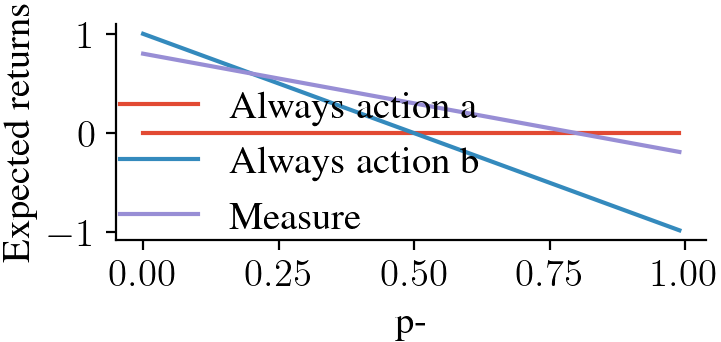

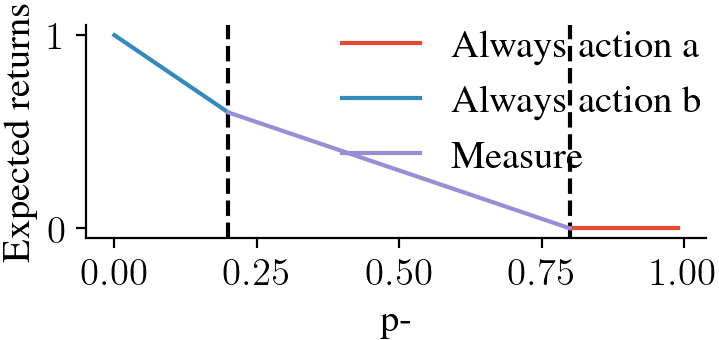

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


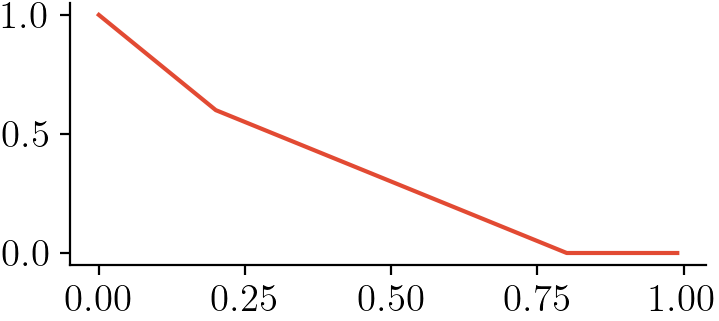

In [4]:
# Plotting optimal returns:

def replace_non_matching(a, aref, value):
    nonmatching = a != aref
    a [nonmatching] = value
    return a

ps = np.arange(start=0, stop=0.99, step=0.001)
c = 0.2
r1 = np.ones_like(ps) * 0.0
r2 = 1 - 2 * ps
r3 = ps*0.0 + (1-ps) - c
# r4 = (c + ps - 1) / (ps - 1)
rmax = np.max([r1, r2, r3], axis=0)
ps_rmax = ps

xaxis = "p-"
yaxis = "Expected returns"

legend = ["Always action a", "Always action b", "Measure"]

plot_lines(x=ps, ys=[r1, r2, r3], legend=legend, show=True, xlabel=xaxis, ylabel=yaxis)

r1, r2, r3 = replace_non_matching(r1, rmax, np.nan), replace_non_matching(r2, rmax, np.nan), replace_non_matching(r3, rmax, np.nan)

plt.axvline(x=c/1, color='k', linestyle='--')
plt.axvline(x=(1-c), color='k', linestyle='--')
plot_lines(x=ps, ys=[r1, r2, r3], legend=legend, show=True, xlabel=xaxis, ylabel=yaxis, save=True, savename=Export_path+"Plots/uMV_optimal.pdf")
plot_lines(x=ps_rmax, ys=[rmax])

#### Same planning, different real

In [5]:
# # Regular runs
# p_plan = 1
# p_plan_set = p_plan / 2
# algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# # algnames = ["ATM", "ATM_Robust", "ATM_Control_Robust"]
# # algnames = ["ATM", "ATM_RMDP"]
# # algnames = ["ATM_Robust", "ATM_Robust"]
# resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
# ps = np.arange(start=0.05, stop=1.0, step=0.01)

# str1 = "Data/Temp1/uMV/AMData_"; str2 = "_uMV_"
# str3 = "_r1_pvar{0}_p{1}_mc02.json".format(float_to_str(p_plan_set), float_to_str(0.5))

# nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(ps)
# nmbr_extra_algs = 2
# all_avgs, all_stds = np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
# avg_rewards, std_rewards = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
# avg_measures, std_measures = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
# avg_steps, std_steps = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))

# all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, ps, str1, str2, str3, smoothen=False)


# # Optimistic and pesimistic Control robustness
# algnames = ["ATM_Control_Robust"]
# str3 = "_r1_pvar{0}_p{1}_m{2}_mc02.json".format(float_to_str(p_plan_set), float_to_str(0.5), float_to_str(1))
# all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, ps, str1, str2, str3, smoothen=False)

# str3 = "_r1_pvar{0}_p{1}_m{2}_mc02.json".format(float_to_str(p_plan_set), float_to_str(0.5), float_to_str(-0.5))
# all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, ps, str1, str2, str3, smoothen=False)



# avg_rewards, std_rewards = all_avgs[:,0,:], all_stds[:,0,:]
# avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
# avg_steps, std_steps = all_avgs[:,1,:], all_stds[:,1,:]

# legend = ["ATM (avg)", "ATM (using RMDP)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
# # legend = ["ATM (avg)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
# # legend = ["ATM_RMDP", "ATM_RMDP"]
# # legend = ["ATM","ATM_Robust", "ATM_Control_Robust (opt)"]
# xaxis = "p-"
# yaxis_r = "Reward"
# yaxis_m = "Measurements"
# yaxis_s = "Steps"

# print(np.shape(all_avgs), legend)
# plt.axvline(x=p_plan, color='k', linestyle='--', label="planning alpha")
# plt.plot(ps_rmax, rmax, color='k', linestyle='--', label="optimal returns")
# plot_lines(avg_rewards, ps, std_rewards, legend=legend, xlabel=xaxis, ylabel=yaxis_r, title="uMV")
# plt.axvline(x=p_plan, color='k', linestyle='--', label="planning alpha")
# plot_lines(avg_measures, ps, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m, title="uMV")
# plt.axvline(x=p_plan, color='k', linestyle='--', label="planning alpha")
# plot_lines(avg_steps, ps, std_steps, legend=legend, xlabel=xaxis, ylabel=yaxis_s, title="uMV")
# # Without non-robust ATM
# # plot_lines(avg_rewards[1:], alphas, std_rewards[1:], legend=legend[1:])

Data\Temp1\AMData_ATM_Control_Robust_uMV_005_r1_pvar05_p05_m1_mc02.json
Data/Temp1/AMData_ATM_Control_Robust_uMV_005_r1_pvar05_p05_mvar05_m1_mc02.json

#### Measuring Behaviour

In [6]:
# Testing measuring behaviour

algnames = ["ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_RMDP"]
# algnames = ["ATM_Robust", "ATM_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
pvars = np.arange(start=0.05, stop=1.0, step=0.01)/2
ps = pvars * 2

str1 = Export_path+"uMV/AMData_"; str2 = "_uMV_05_r1_pvar"
str3 = "_p{0}_mc02.json".format(float_to_str(0.5))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(pvars)
nmbr_extra_algs = 2
all_avgs, all_stds = np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
avg_rewards, std_rewards = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
avg_measures, std_measures = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
avg_steps, std_steps = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))

all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)


# Optimistic and pesimistic Control robustness
algnames = ["ATM_Control_Robust"]
str3 = "_p{0}_m{1}_mc02.json".format(float_to_str(0.5), float_to_str(1))
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)

str3 = "_p{0}_m{1}_mc02.json".format(float_to_str(0.5), float_to_str(-0.5))
all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)

avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]

legend = ["ATM", "uATM", "ucATM-pes", "ucATM-avg", "ucATM-pes"]
xaxis = "p- (planning)"
yaxis_m = "Measuring (Y/N)"

# plt.axvline(x=c, color='k', linestyle='--')
# plt.axvline(x=(1-c), color='k', linestyle='--')
# for i in range(nmbralgs+nmbr_extra_algs):
#     this_ps = ps[avg_measures[i]>0]
#     this_avg_measures, this_std_measures = avg_measures[i][avg_measures[i]>0]*(i+1), std_measures[i][avg_measures[i]>0]*(i+1)
#     plot_lines([this_avg_measures], this_ps, [this_std_measures], legend=[legend[i]], show=False)

# ax = plt.gca()
# ax.get_yaxis().set_visible(False)
# plt.xlim([0, 1])
# plt.xlabel(xaxis)

# plt.axis()
# plt.savefig(Export_path+"uMV_Measuring.pdf")
# plt.show()


##### Measuring behaviour as subplots

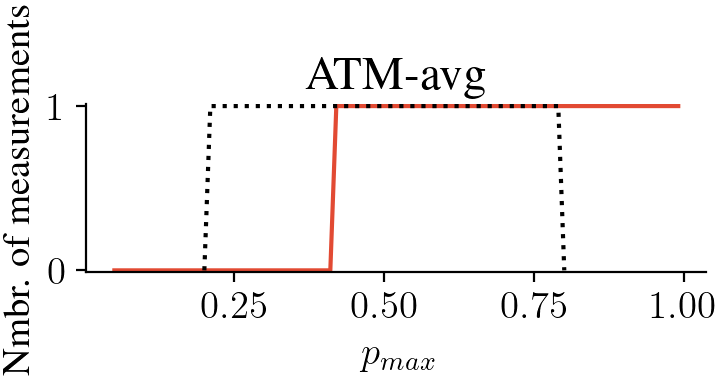

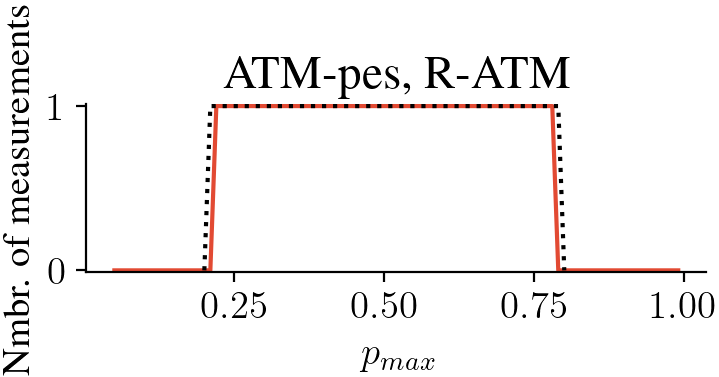

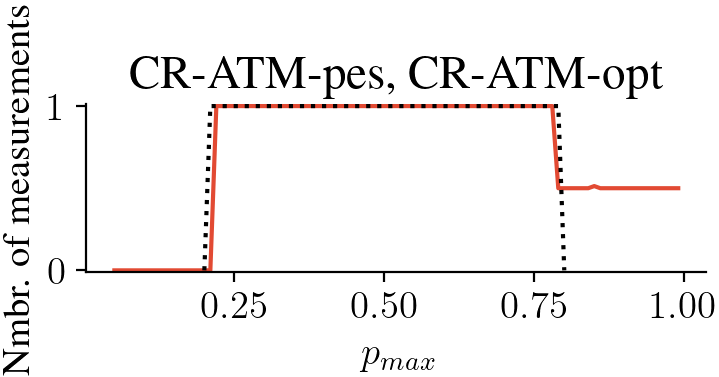

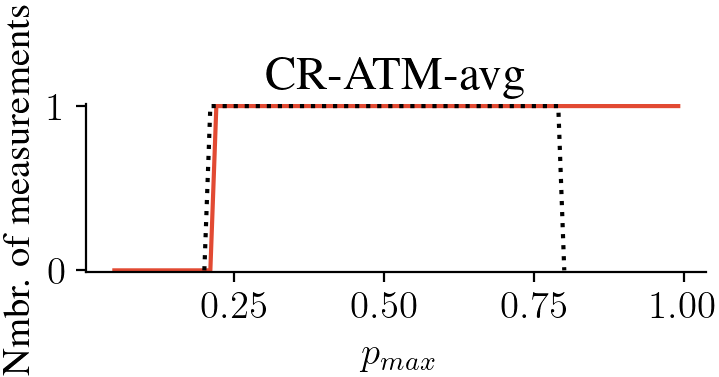

In [13]:
# We use the fact that through testing, ATM_RMPD, uAMT & uATM_pes have the same measuring behaviour,
# as do uATM-avg and uATM-pes. Thus, we just plot those together.

# algnames = ["ATM", "ATM_Control_Robust"]
algnames = ["ATM", "ATM_RMDP", "ATM_Control_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
pvars = np.arange(start=0.05, stop=1.0, step=0.01)/2
ps = pvars * 2
str1 = Export_path+"uMV/AMData_"; str2 = "_uMV_05_r1_pvar"
str3 = "_p{0}_mc02.json".format(float_to_str(0.5))

results1, _stds = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)

algnames = ["ATM_Control_Robust"]
# str3 = "_p{0}_m-{0}_mc02.json".format(float_to_str(0.5))
# results2, _stds = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)
str3 = "_p{0}_m1_mc02.json".format(float_to_str(0.5))
results3, _stds = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)

# measures = [results1[0,2,:], results1[1,2,:], results2[0,2,:]]
measures = [results1[0,2,:], results1[1,2,:], results1[2,2,:], results3[0,2,:]]

legend = ["ATM-avg", "ATM-pes, R-ATM", "CR-ATM-pes, CR-ATM-opt", "CR-ATM-avg", "...", "..."]
xlabel = r'$p_{max}$'
ylabel = r"{Measurements}"

optimalx, optimaly = np.arange(0.2, 0.8, 0.01), np.append(0, np.append(np.ones(59), 0))

for i in range(len(measures)):
    plt.plot(ps, measures[i], label=legend[i])
    plt.plot(optimalx, optimaly, color='k', linestyle="dotted")
    # plt.axvline(x=0.2, color='k', linestyle='--')
    # plt.axhline(y=1, xmin=0.2, xmax=0.8, color='k', linestyle='--')
    # plt.axvline(x=0.8, color='k', linestyle='--')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title(legend[i])
    plt.ylim([-0.01,1.01])
    plt.savefig(Export_path+f"Plots/uMV_sub{i}.pdf")
    plt.show()

### Test on uMV2 environment

#### Plotting in one graph:

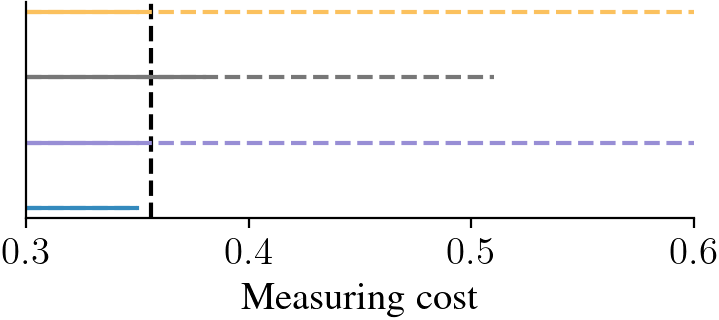

c:\Users\merli\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\merli\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


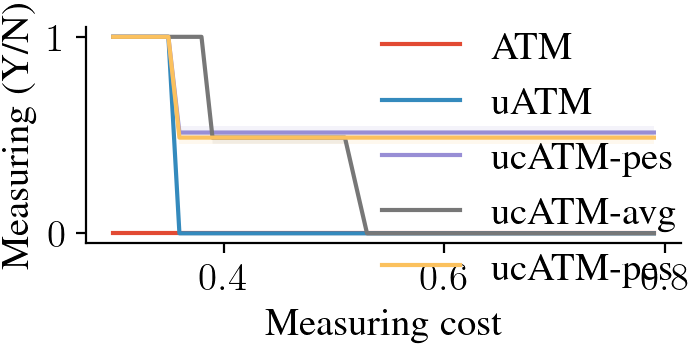

In [8]:
# Testing measuring behaviour

algnames = ["ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_RMDP"]
# algnames = ["ATM_Robust", "ATM_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
mcs = np.arange(start=0.3, stop=0.8, step=0.01)

str1 = Export_path+"uMV2/AMData_"; str2 = "_uMV2_08_r00001_p00001_mc"
str3 = ".json".format(float_to_str(0.5))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(mcs)
nmbr_extra_algs = 2
all_avgs, all_stds = np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
avg_rewards, std_rewards = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
avg_measures, std_measures = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
avg_steps, std_steps = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))

all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, mcs, str1, str2, str3, smoothen=False)


# Optimistic and pesimistic Control robustness
algnames = ["ATM_Control_Robust"]
str2 = "_uMV2_08_r00001_p00001_m1_mc"
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, mcs, str1, str2, str3, smoothen=False)

str2 = "_uMV2_08_r00001_p00001_m-00001_mc"
all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, mcs, str1, str2, str3, smoothen=False)

avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]

legend = ["ATM", "uATM", "ucATM-pes", "ucATM-avg", "ucATM-pes"]
xaxis = "Measuring cost"
yaxis_m = "Measuring (Y/N)"

plt.axvline(x=0.356, color='k', linestyle='--')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(nmbralgs+nmbr_extra_algs):
    
    filter_always_measure = avg_measures[i]>0.7
    mcs_full = mcs[filter_always_measure]
    avg_measures_full= avg_measures[i][filter_always_measure]*(i+1)
    plt.plot(mcs_full, avg_measures_full, label=legend[i], color=colors[i])
    
    filter_sometimes_measure = avg_measures[i]>0.25
    mcs_sometimes = mcs[filter_sometimes_measure]
    avg_measures_sometimes = np.ones_like(avg_measures[i])[filter_sometimes_measure]*(i+1)
    plt.plot(mcs_sometimes, avg_measures_sometimes, color=colors[i], linestyle='--')
    
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.xlim([0.3, 0.6])
plt.xlabel(xaxis)

plt.axis()
# plt.savefig(Export_path+"uMV2_Measuring.pdf")
plt.show()


plot_lines(avg_measures, mcs, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m)

#### Plotting as subplots

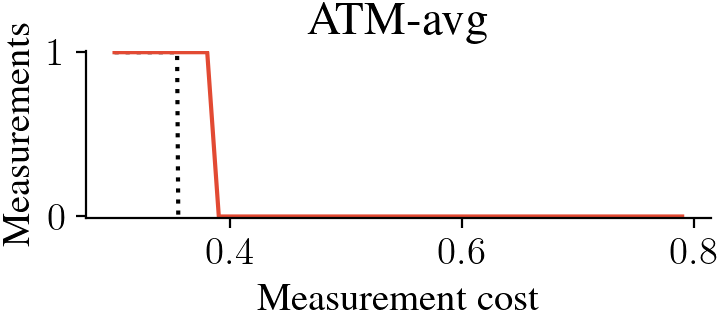

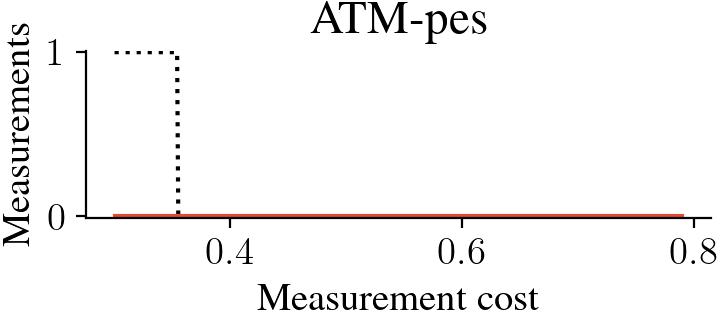

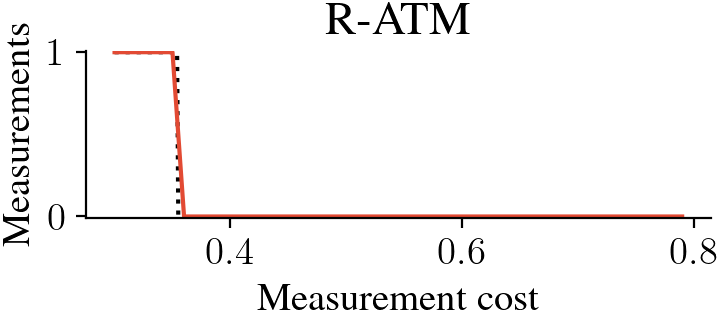

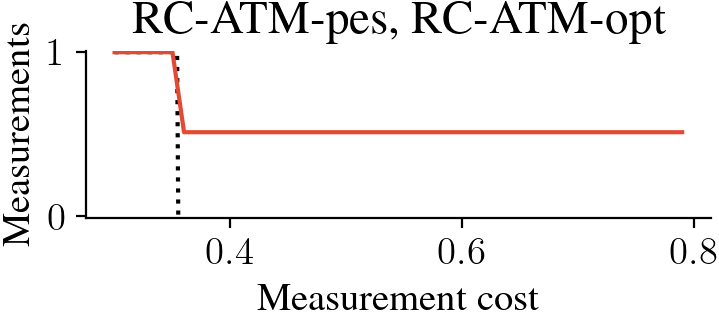

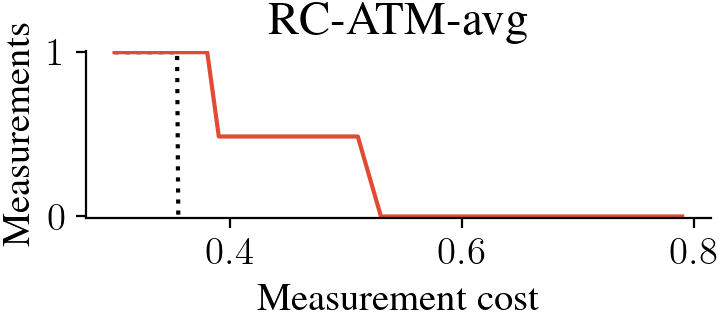

In [9]:
algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
measure_costs = np.arange(start=0.3, stop=0.8, step=0.01)
str1 = Export_path+"uMV2/AMData_"; str2 = "_uMV2_08_r00001_p00001_mc"
str3 = ".json".format(float_to_str(0.5))

results1, _stds = collect_data_from_files(algnames, resultvars, measure_costs, str1, str2, str3, smoothen=False)

algnames = ["ATM_Control_Robust"]
str2 = "_uMV2_08_r00001_p00001_m1_mc"
results2, _stds = collect_data_from_files(algnames, resultvars, measure_costs, str1, str2, str3, smoothen=False)

measures = [results1[0,2,:],results1[1,2,:],results1[2,2,:],results1[3,2,:],  results2[0,2,:]]

legend = ["ATM-avg", "ATM-pes", "R-ATM", "RC-ATM-pes, RC-ATM-opt", "RC-ATM-avg"]
xlabel = "Measurement cost"
ylabel = "Measurements"

optimalx, optimaly = np.arange(0.3, 0.356, 0.001), np.append(np.ones(55), 0)

for i in range(len(measures)):
    # plt.axvline(x=0.356, color='k', linestyle='dotted')
    plt.plot(optimalx, optimaly, color='k', linestyle="dotted")
    plt.plot(measure_costs, measures[i], label=legend[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(legend[i])
    plt.ylim([-0.01,1.01])
    plt.savefig(Export_path+f"Plots/uMV2_sub{i}.pdf")
    plt.show()

### Test on Drone Env

Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r03_p03_m-03_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r035_p035_m-035_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r04_p04_m-04_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r045_p045_m-045_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r05_p05_m-05_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r055_p055_m-055_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r06_p06_m-06_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r065_p065_m-065_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r07_p07_m-07_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r075_p075_m-075_mc005.json
Data/Robust_Results/Drone/AMData_ATM_Control_Robust_Drone_narrow_r08_p08_m-08_mc005.json
Data/R

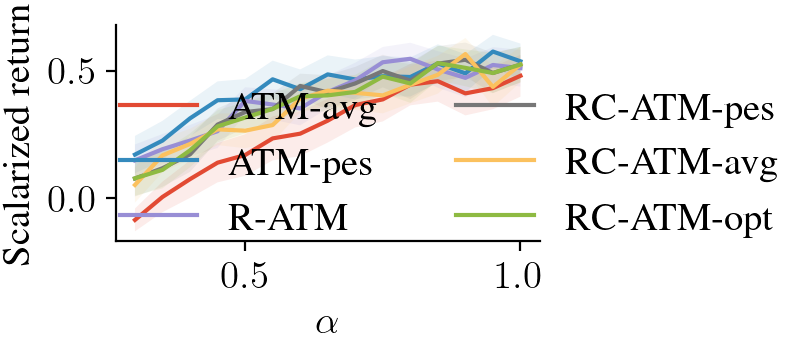

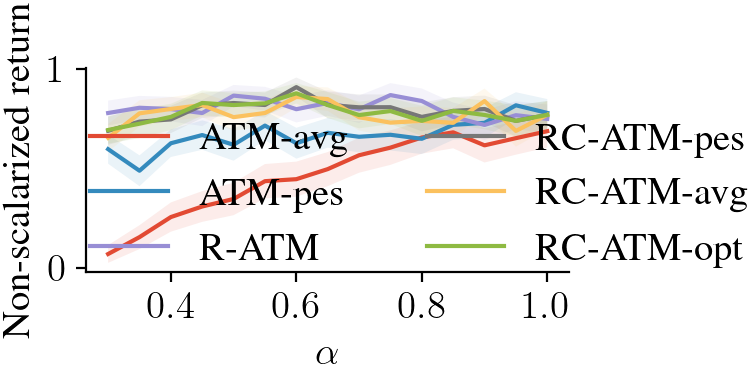

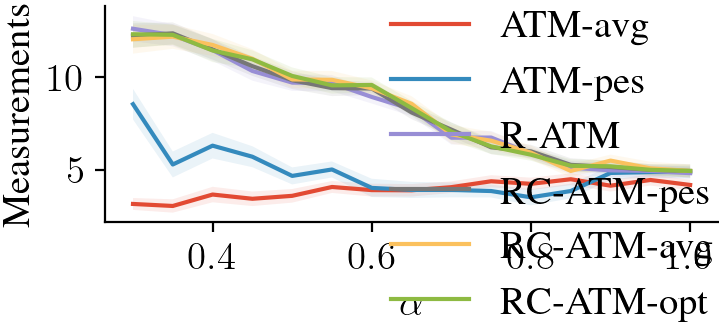

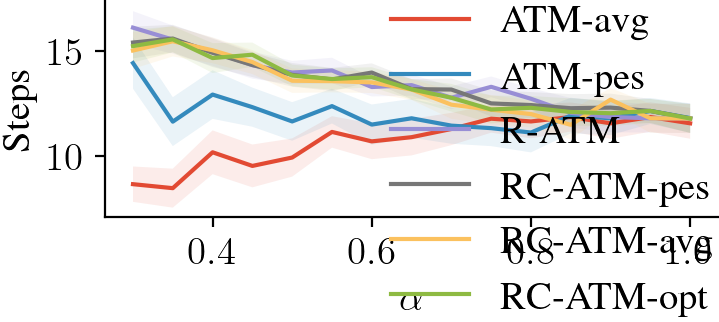

In [10]:
# Regular runs
cost = 0.05
algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
alphas = np.round(np.arange(start=0.3, stop=1.01, step=0.05), decimals=2)
str1 = Export_path+"Drone/AMData_"; str2 = "_Drone_narrow_r"; str3 = "_mc{}.json".format( float_to_str(cost))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(alphas)
nmbr_extra_algs = 2
all_avgs, all_stds = np.empty((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.empty((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=False)

# Avg and optimistic Control robustness
algnames = ["ATM_Control_Robust"]
str3 = "_m1_mc{}.json".format(float_to_str(cost))
alphas_ = np.copy(alphas); alphas_[-1] = alphas[0]
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, alphas_, str1, str2, str3, smoothen=False)
all_avgs[nmbralgs,:,-1], all_stds[nmbralgs,:,-1] = all_avgs[nmbralgs-1,:,-1], all_stds[nmbralgs-1,:,-1]


str3 = "_mc{}.json".format(float_to_str(cost))
all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=False, opt = True)

avg_rewards, std_rewards = all_avgs[:,0,:], all_stds[:,0,:]
avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
avg_steps, std_steps = all_avgs[:,1,:], all_stds[:,1,:]

legend = ["ATM-avg", "ATM-pes", "R-ATM", "RC-ATM-pes", "RC-ATM-avg", "RC-ATM-opt"]

xaxis = r"$\alpha$"
yaxis_r = "Scalarized return"
yaxis_rm = "Non-scalarized return"
yaxis_m = "Measurements"
yaxis_s = "Steps"

plot_lines(avg_rewards, alphas, std_rewards, legend=legend, legend_columns=2, xlabel=xaxis, ylabel=yaxis_r, save=True, savename=Export_path+"Plots/DroneRegularReturnsZoomed.pdf")
plot_lines(avg_rewards+avg_measures*cost, alphas, std_rewards, legend=legend,legend_columns=2, xlabel=xaxis, ylabel=yaxis_rm, save=True, savename=Export_path+"Plots/DroneRegularReachZoomed.pdf")

plot_lines(avg_measures, alphas, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m)
plot_lines(avg_steps, alphas, std_steps, legend=legend, xlabel=xaxis, ylabel=yaxis_s)

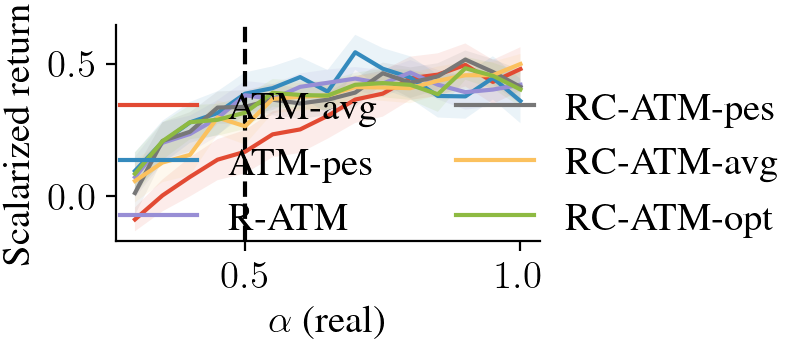

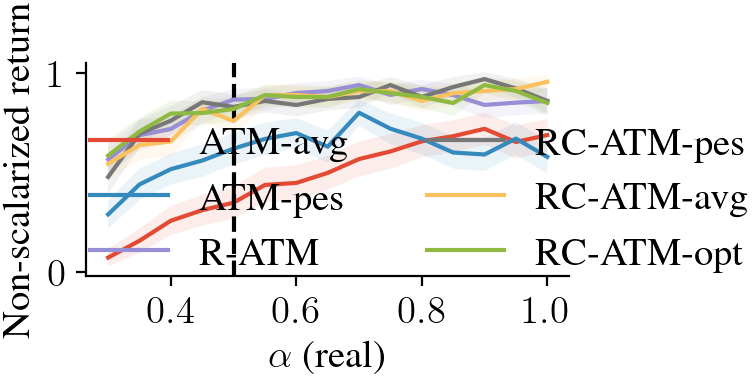

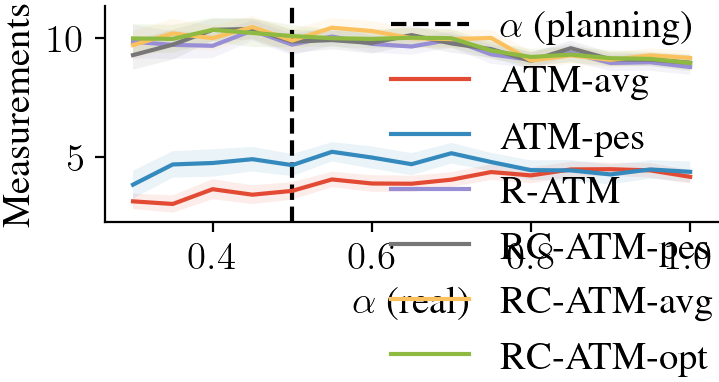

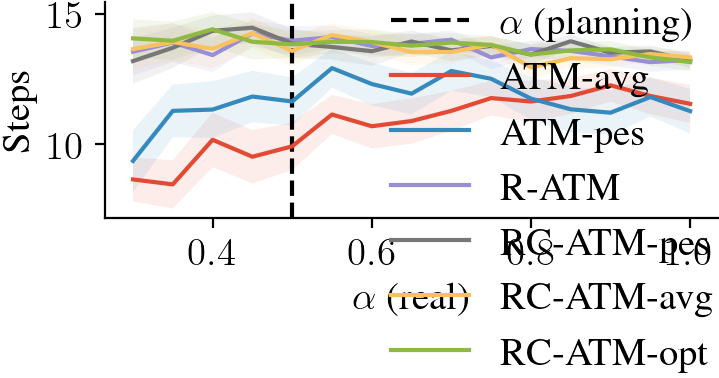

In [11]:
# 'general'
plan_value = 0.5
cost = 0.05
algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_Robust", "ATM_Control_Robust"]
# algnames = [ "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = [ "ATM_RMDP", "ATM_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
alphas = np.round(np.arange(start=0.3, stop=1.01, step=0.05), decimals=2)
str1 = Export_path+"Drone/AMData_"; str2 = "_Drone_narrow_r"; str3 = "_p{}_mc{}.json".format(float_to_str(plan_value), float_to_str(cost))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(alphas)
nmbr_extra_algs = 2
all_avgs, all_stds = np.empty((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.empty((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=False)

# Avg and optimistic Control robustness
algnames = ["ATM_Control_Robust"]
str3 = "_p{0}_m1_mc{1}.json".format(float_to_str(plan_value), float_to_str(cost))
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=False)

str3 = "_p{0}_m-{0}_mc{1}.json".format(float_to_str(plan_value), float_to_str(cost))
all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=False)

avg_rewards, std_rewards = all_avgs[:,0,:], all_stds[:,0,:]
avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
avg_steps, std_steps = all_avgs[:,1,:], all_stds[:,1,:]

# avg_rewards += avg_measures*0.05

legend = ["ATM-avg", "ATM-pes", "R-ATM", "RC-ATM-pes", "RC-ATM-avg", "RC-ATM-opt"]
# legend = ["ATM", "uATM", "ucATM-opt"]
# legend = ["ATM (RMDP)", "ATM_Robust", "ATM_Control_Robust (opt)"]
# legend = ["ATM (RMDP)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (opt)"]

xaxis = r"$\alpha$ (real)"
yaxis_r = "Scalarized return"
yaxis_rm = "Non-scalarized return"
yaxis_m = "Measurements"
yaxis_s = "Steps"

lineLabel = r"$\alpha$ (planning)"

plt.axvline(x=plan_value, color='k', linestyle='--')#, label=lineLabel)
plot_lines(avg_rewards, alphas, std_rewards, legend=legend, legend_columns=2, xlabel=xaxis, ylabel=yaxis_r, save=True, savename=Export_path+"Plots/DroneReturnsZoomed.pdf")
plt.axvline(x=plan_value, color='k', linestyle='--')#, label=lineLabel)
plot_lines(avg_rewards+avg_measures*cost, alphas, std_rewards, legend=legend, legend_columns=2, xlabel=xaxis, ylabel=yaxis_rm, save=True, savename=Export_path+"Plots/DroneReachZoomed.pdf")

plt.axvline(x=plan_value, color='k', linestyle='--', label=lineLabel)
plot_lines(avg_measures, alphas, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m)
plt.axvline(x=plan_value, color='k', linestyle='--', label=lineLabel)
plot_lines(avg_steps, alphas, std_steps, legend=legend, xlabel=xaxis, ylabel=yaxis_s)
# Without non-robust ATM
# plot_lines(avg_rewards[1:], alphas, std_rewards[1:], legend=legend[1:])

Data\Temp1\Drone\AMData_ATM_Control_Robust_Drone_narrow_r03_p03_m-03_mc005.json
Data/Temp1/Drone/AMData_ATM_RMDP_Drone_narrow_r03_p03_m-03_mc005.json